In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs

import warnings
warnings.filterwarnings('ignore')

In [30]:
# import data
data = pd.read_csv('time_series_covid19_confirmed_global.csv')

In [74]:
data.head(5)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,1/2/22,1/3/22,1/4/22,1/5/22,1/6/22,1/7/22,1/8/22,1/9/22,1/10/22,1/11/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,158189,158183,158205,158245,158275,158300,158309,158381,158394,158471
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,210885,210885,212021,212021,213257,214905,214905,219694,220487,222664
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,219159,219532,219953,220415,220825,221316,221742,222157,222639,223196
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,23740,24502,24802,25289,25289,26408,26408,26408,27983,28542
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,82920,83764,84666,86636,87625,88775,89251,89718,90316,91148


In [31]:
# select Portugal data
dados_portugal = data[data['Country/Region'] == 'Portugal']
dados_portugal.drop(columns = ['Province/State', 'Lat', 'Long', 'Country/Region'], inplace = True)
dados_portugal = dados_portugal.T

In [4]:
dados_portugal.head(5)

,214
1/22/20,0
1/23/20,0
1/24/20,0
1/25/20,0
1/26/20,0


In [32]:
# Converting the index as date
dados_portugal.index = pd.to_datetime(dados_portugal.index, format='%m/%d/%y')

In [6]:
dados_portugal.head()

,214
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0


In [33]:
dados_portugal.rename(columns={214:'CumCases'}, inplace=True)

In [8]:
dados_portugal.head(10)

,CumCases
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
2020-01-27,0
2020-01-28,0
2020-01-29,0
2020-01-30,0
2020-01-31,0


In [34]:
dados_portugal.reset_index(inplace=True)

In [10]:
dados_portugal

,index,CumCases
0,2020-01-22,0
1,2020-01-23,0
2,2020-01-24,0
3,2020-01-25,0
4,2020-01-26,0
...,...,...
716,2022-01-07,1577784
717,2022-01-08,1613427
718,2022-01-09,1639846
719,2022-01-10,1660058


In [35]:
# convert from cumulative to daily cases
casos = np.array([0])
for i in range(dados_portugal.shape[0] - 1):
    casos = np.append(casos, [dados_portugal.CumCases[i+1] - dados_portugal.CumCases[i]])
dados_portugal['DailyCases'] = pd.Series(casos)   

In [36]:
dados_portugal.tail()

,index,CumCases,DailyCases
716,2022-01-07,1577784,38734
717,2022-01-08,1613427,35643
718,2022-01-09,1639846,26419
719,2022-01-10,1660058,20212
720,2022-01-11,1693398,33340


In [37]:
dados_portugal.rename(columns={'index':'Date'}, inplace=True)

In [14]:
dados_portugal.head(10)

,Date,CumCases,DailyCases
0,2020-01-22,0,0
1,2020-01-23,0,0
2,2020-01-24,0,0
3,2020-01-25,0,0
4,2020-01-26,0,0
5,2020-01-27,0,0
6,2020-01-28,0,0
7,2020-01-29,0,0
8,2020-01-30,0,0
9,2020-01-31,0,0


In [38]:
series = dados_portugal.set_index('Date')
series.drop('CumCases', axis=1, inplace=True)

In [16]:
series.head(5)

,DailyCases
Date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0


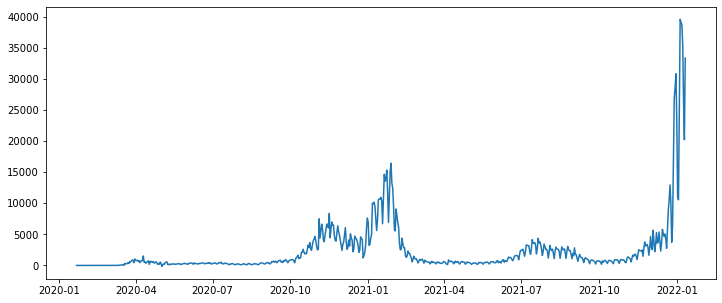

In [39]:
# plot series
plt.figure(figsize=(12,5))
plt.plot(series['DailyCases'])
plt.show()

In [40]:
# Tail-rolling average transform
rolling = series.rolling(window=7)
rolling_mean = rolling.mean()

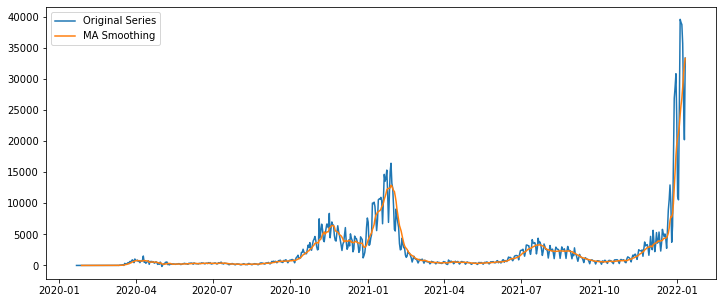

In [41]:
plt.figure(figsize=(12,5))
plt.plot(series['DailyCases'], label='Original Series')
plt.plot(rolling_mean['DailyCases'], label = 'MA Smoothing')
plt.legend()
plt.show()

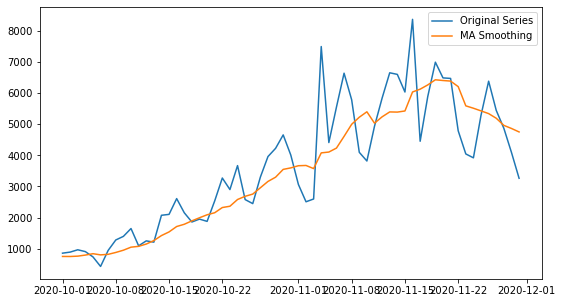

In [42]:
plt.figure(figsize=(9,5))
plt.plot(series.loc['2020-10-01':'2020-11-30','DailyCases'], label='Original Series')
plt.plot(rolling_mean.loc['2020-10-01':'2020-11-30','DailyCases'], label = 'MA Smoothing')
plt.legend()
plt.show()

In [43]:
# split into train and test data
df_train = rolling_mean.loc['2020-10-01':'2020-11-30',:]
df_test = rolling_mean.loc['2020-12-01':'2020-12-07',:]

In [44]:
df_train.head()

,DailyCases
Date,
2020-10-01,748.571429
2020-10-02,747.000000
2020-10-03,758.285714
2020-10-04,792.428571
2020-10-05,836.571429


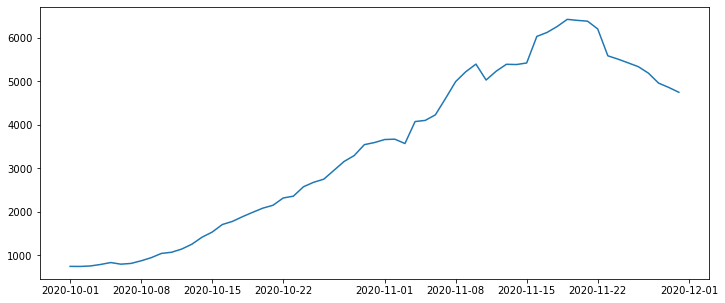

In [45]:
# plot train data
plt.figure(figsize=(12,5))
plt.plot(df_train['DailyCases'])
plt.show()

In [98]:
# testing for stationarity
#Ho: Its stationary
#Ho: Its not stationary

def kpss_test(cases):
    result=kpss(cases)
    labels = ['KPSS Test Statistic','p-value','#Lags Used','Critical value for a significance level']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has a unit root and is not stationary")
    else:
        print("Weak evidence against null hypothesis that means time series doesn't have a unit root which indicates that it is stationary ")
        
## Adf Test
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+ str(value) )
    if result[1] <= 0.05:
        print("P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary ")

In [104]:
kpss_test(df_train['DailyCases'])

KPSS Test Statistic : 1.0448243400489037
p-value : 0.01
#Lags Used : 5
Critical value for a significance level : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has a unit root and is not stationary


In [105]:
adfuller_test(df_train['DailyCases'])

ADF Test Statistic : -3.0103398842000018
p-value : 0.0339400032236019
#Lags Used : 10
Number of Observations Used : 50
P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary


In [106]:
# according with both tests we have a unit root and the series is not stationary. but how many differences should we have?

## Adf Test
print(ndiffs(df_train['DailyCases'], test='adf'))  # 2

# KPSS test
print(ndiffs(df_train['DailyCases'], test='kpss')) #1

2
1


In [ ]:
# according with adf we should have 1 difference and 2 according with kpss

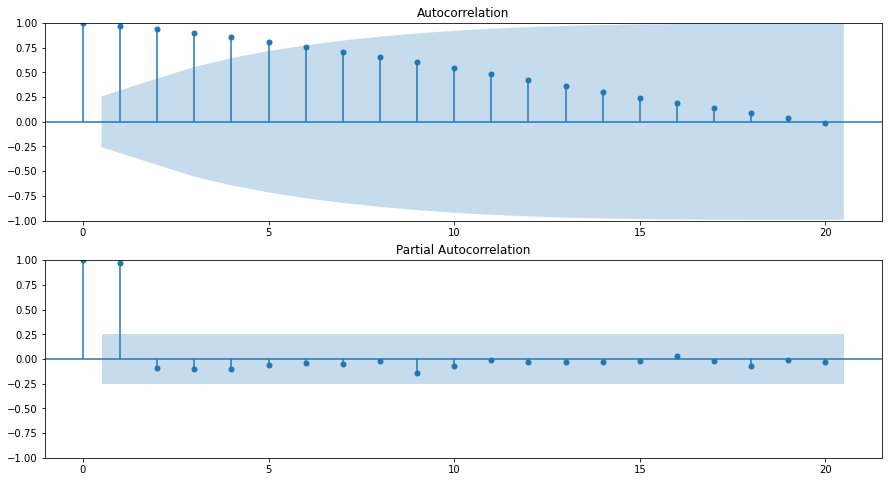

In [69]:
## correlogram
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_train['DailyCases'].iloc[3:],lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_train['DailyCases'].iloc[3:],lags=20,ax=ax2, method='ywm')

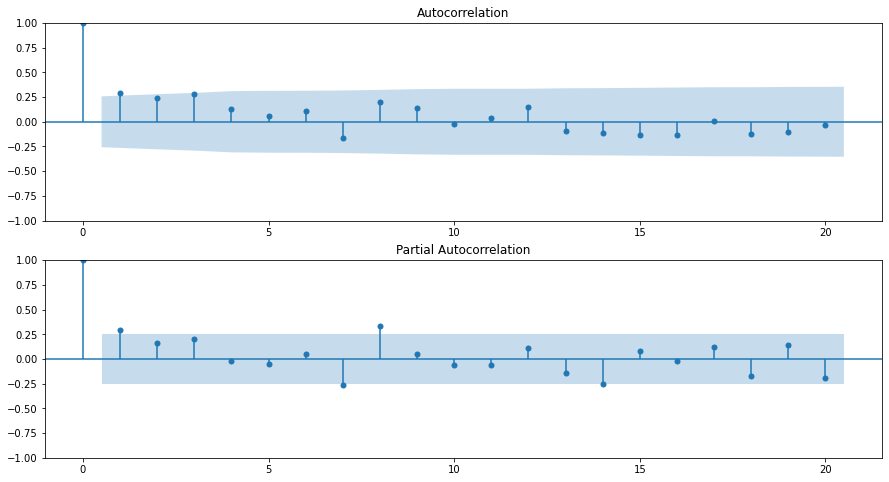

In [70]:
## correlogram for 1 difference
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_train['DailyCases'].diff().iloc[3:],lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_train['DailyCases'].diff().iloc[3:],lags=20,ax=ax2, method='ywm')

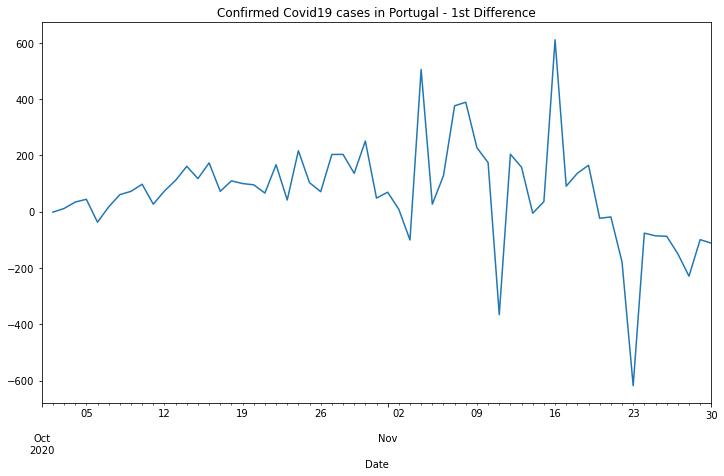

In [101]:
df_train.DailyCases.diff().plot(figsize=(12,7))
plt.title('Confirmed Covid19 cases in Portugal - 1st Difference')
plt.show()

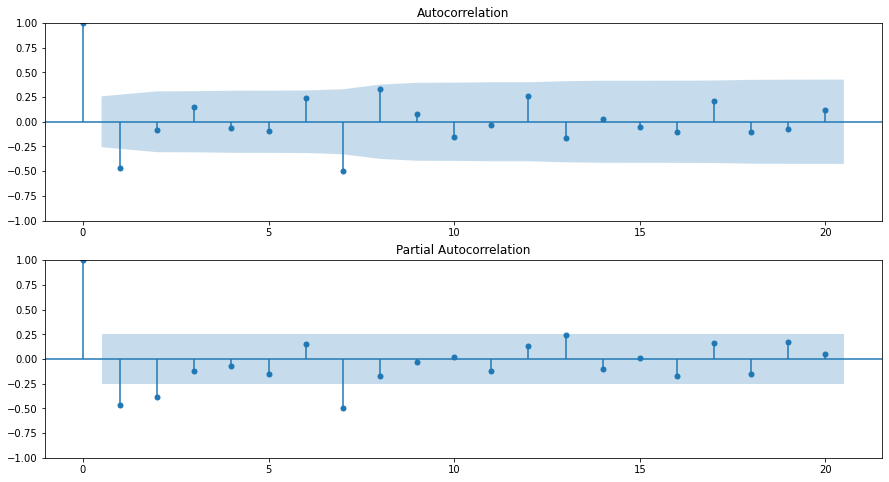

In [107]:
## correlogram for 2 difference
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_train['DailyCases'].diff().diff().iloc[3:],lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_train['DailyCases'].diff().diff().iloc[3:],lags=20,ax=ax2, method='ywm')

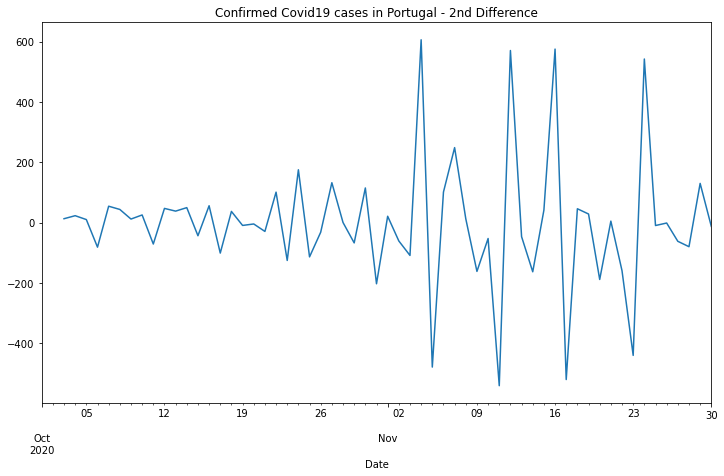

In [102]:
df_train.DailyCases.diff().diff().plot(figsize=(12,7))
plt.title('Confirmed Covid19 cases in Portugal - 2nd Difference')
plt.show()

In [115]:
## correlogram for 2 differences
# fig = plt.figure(figsize=(15,8))
# ax1 = fig.add_subplot(211)
# fig = sm.graphics.tsa.plot_acf(series['DailyCases'].diff().diff().iloc[3:],lags=20,ax=ax1)
# ax2 = fig.add_subplot(212)
# fig = sm.graphics.tsa.plot_pacf(series['DailyCases'].diff().diff().iloc[3:],lags=20,ax=ax2, method='ywm')

In [116]:
# series.DailyCases.diff().diff().plot(figsize=(15,8))
# plt.title('Confirmed Covid19 cases in Portugal - 2nd Difference')
# plt.show()

In [81]:
# decompose = seasonal_decompose(series.DailyCases, model='addictive', period=30)

In [90]:
# trend_estimate = decompose.trend
# periodic_estimate = decompose.seasonal
# residual = decompose.resid

In [117]:
# plt.figure(figsize=(12,10))
# plt.subplot(411)
# plt.plot(series.DailyCases,label='Original time series', color='blue')
# plt.legend(loc='best')
# plt.subplot(412)
# plt.plot(trend_estimate,label='Trend of time series',color='blue')
# plt.legend(loc='best')
# plt.subplot(413)
# plt.plot(periodic_estimate,label='Seasonality of time series',color='blue')
# plt.legend(loc='best')
# plt.subplot(414)
# plt.plot(residual,label='Decomposition residuals of time series',color='blue')
# plt.legend(loc='best')
# plt.tight_layout()
# #plt.savefig('decomposition.png')

In [95]:
# residual.describe()

count      691.000000
mean       -98.168192
std       1129.368520
min     -11372.496453
25%       -272.722178
50%        -29.513120
75%        208.186880
max       6861.204996
Name: resid, dtype: float64

In [118]:
# ## correlogram for the residual
# fig = plt.figure(figsize=(15,8))
# ax1 = fig.add_subplot(211)
# fig = sm.graphics.tsa.plot_acf(residual.dropna(),lags=20,ax=ax1)
# ax2 = fig.add_subplot(212)
# fig = sm.graphics.tsa.plot_pacf(residual.dropna(),lags=20,ax=ax2, method='ywm')

In [119]:
# ## correlogram for the residual
# fig = plt.figure(figsize=(15,8))
# ax1 = fig.add_subplot(211)
# fig = sm.graphics.tsa.plot_acf(residual.diff().dropna(),lags=20,ax=ax1)
# ax2 = fig.add_subplot(212)
# fig = sm.graphics.tsa.plot_pacf(residual.diff().dropna(),lags=20,ax=ax2, method='ywm')

In [120]:
# residual.dropna().plot(figsize=(15,8))
# plt.title('Confirmed Covid19 cases in Portugal - 2nd Difference')
# plt.show()

In [46]:
# fit ARIMA model with different orders

orders = [(2,2,1),(1,2,1),(0,2,1)]

for i in range(len(orders)):
    model = ARIMA(endog=df_train.DailyCases,order=orders[i])
    model_fit=model.fit()
    print('AIC: {} / BIC: {}'.format(round(model_fit.aic,2),round(model_fit.bic,2)))

AIC: 783.23 / BIC: 791.54
AIC: 781.24 / BIC: 787.47
AIC: 779.3 / BIC: 783.45


In [109]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             DailyCases   No. Observations:                   61
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -387.649
Date:                Mon, 24 Jan 2022   AIC                            779.297
Time:                        12:46:17   BIC                            783.452
Sample:                    10-01-2020   HQIC                           780.919
                         - 11-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7701      0.075    -10.292      0.000      -0.917      -0.623
sigma2      2.941e+04   2837.829     10.362      0.000    2.38e+04     3.5e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                73.21
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              28.66   Skew:                            -0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

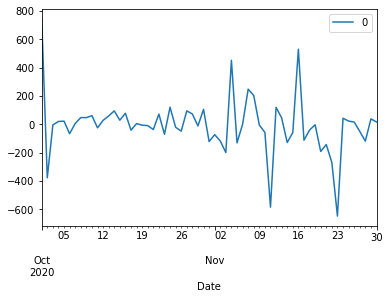

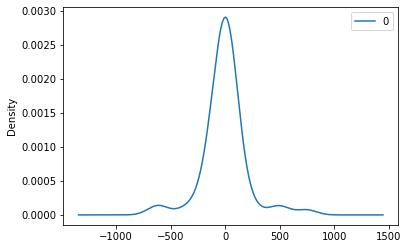

                0
count   61.000000
mean    -4.060187
std    201.442324
min   -646.759574
25%    -64.997122
50%     -2.036515
75%     48.711624
max    748.571429


In [110]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

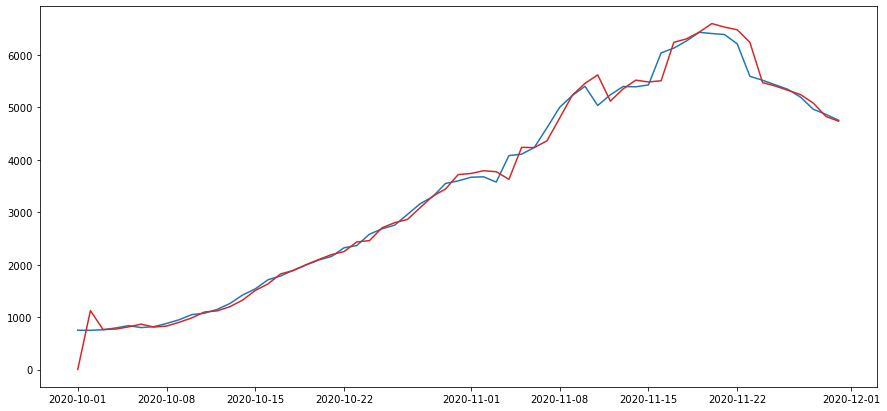

In [111]:
plt.figure(figsize=(15,7))
plt.plot(df_train.index, df_train.DailyCases, color='tab:blue')
plt.plot(df_train.index, model_fit.fittedvalues, color='tab:red')
#plt.fill_between(df_predictions.index, df_predictions['lower Dailycases'],df_predictions['upper Dailycases'], color='lightpink')

In [120]:
# out-sample forecast
forecast = model_fit.get_forecast(7)

In [121]:
mean_forecast = forecast.predicted_mean
ci_forecast = forecast.conf_int()

In [122]:
mean_forecast

2020-12-01    4625.759805
2020-12-02    4500.233895
2020-12-03    4374.707986
2020-12-04    4249.182077
2020-12-05    4123.656167
2020-12-06    3998.130258
2020-12-07    3872.604348
Freq: D, Name: predicted_mean, dtype: float64

In [123]:
ci_forecast

,lower DailyCases,upper DailyCases
2020-12-01,4289.661080,4961.858530
2020-12-02,3967.461585,5033.006206
2020-12-03,3650.417233,5098.998739
2020-12-04,3328.769244,5169.594910
2020-12-05,2999.610106,5247.702228
2020-12-06,2661.903654,5334.356862
2020-12-07,2315.308326,5429.900371


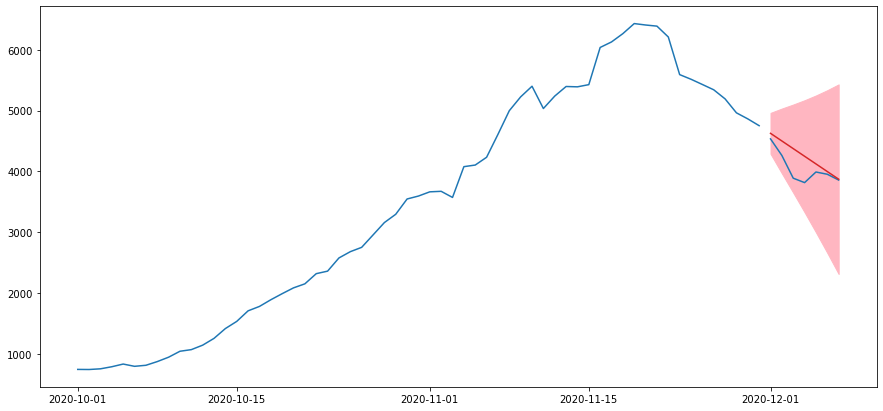

In [124]:
plt.figure(figsize=(15,7))
plt.plot(df_train.index, df_train.DailyCases, color='tab:blue')
plt.plot(df_test.index, df_test.DailyCases, color='tab:blue')
plt.plot(mean_forecast.index,mean_forecast, color='tab:red')
plt.fill_between(mean_forecast.index, ci_forecast['lower DailyCases'],ci_forecast['upper DailyCases'], color='lightpink')